In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [23]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
data = pd.read_csv('driver_imgs_list.csv')
print(data)

X_train = pd.read_csv('driver_imgs_list.csv')['img']
y_train = pd.read_csv('driver_imgs_list.csv')['classname']

print(X_train.shape)
print(y_train.shape)

NUM_TRAIN = X_train.shape[0]

      subject classname            img
0        p002        c0  img_44733.jpg
1        p002        c0  img_72999.jpg
2        p002        c0  img_25094.jpg
3        p002        c0  img_69092.jpg
4        p002        c0  img_92629.jpg
...       ...       ...            ...
22419    p081        c9  img_56936.jpg
22420    p081        c9  img_46218.jpg
22421    p081        c9  img_25946.jpg
22422    p081        c9  img_67850.jpg
22423    p081        c9   img_9684.jpg

[22424 rows x 3 columns]
(22424,)
(22424,)


In [21]:
datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255)

train_images = datagen.flow_from_directory(
    'imgs/train/',
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    subset='training')

validation_images = datagen.flow_from_directory(
    'imgs/train/',
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    subset='validation')

print(train_images.shape)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


AttributeError: 'DirectoryIterator' object has no attribute 'shape'

In [12]:
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [15]:
train_dataset = dset.ImageFolder(root='imgs/train/',transform=T.Compose([T.Resize((224,224)),T.ToTensor()]))
train_indices = np.random.choice(NUM_TRAIN,int(0.8*NUM_TRAIN),replace=False)
val_indices = []
for idx in range(NUM_TRAIN):
    if idx not in train_indices:
        val_indices.append(idx)
        
val_indices = np.array(val_indices)
train = Subset(train_dataset,train_indices)
val = Subset(train_dataset,val_indices)


# test_dataset = dset.ImageFolder(root='imgs/test/',transform=T.Compose([T.Resize((224,224)),T.ToTensor()]))

train_loader = DataLoader(dataset=train,batch_size=batch_size,shuffle=True)

val_loader = DataLoader(dataset=val,batch_size=batch_size,shuffle=True)

# test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

torch.Size([100, 3, 224, 224]) torch.Size([100])


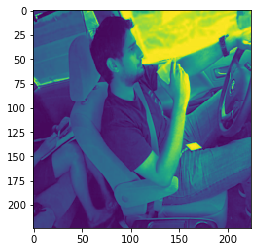

In [20]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

plt.imshow(images[0,0,:,:])

In [26]:
def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        with torch.no_grad():
          x_var = x.type(gpu_dtype)
        # x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [25]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [24]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=7, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=7, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2))
        self.fc = nn.Linear(28*28*64, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0),-1)
        out = self.fc(out)
        return out
    
model = ConvNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [25]:
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=50176, out_features=10, bias=True)
)


In [26]:
print(model.layer1.parameters)

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)>


In [27]:
list(model.layer1.parameters())[0].shape

torch.Size([16, 3, 5, 5])

In [29]:
# train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-4ca964496c18>", line 9, in <module>
    outputs = model(images)
  File "c:\python36\lib\site-packages\torch\nn\modules\module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-24-8a9e68097a17>", line 22, in forward
    out = self.layer1(x)
  File "c:\python36\lib\site-packages\torch\nn\modules\module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "c:\python36\lib\site-packages\torch\nn\modules\container.py", line 92, in forward
    input = module(input)
  File "c:\python36\lib\site-packages\torch\nn\modules\module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "c:\python36\lib\site-packages\torch\nn\modules\batchnorm.py", line 81, in forward
    exponential_average_factor, s

KeyboardInterrupt: 